[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jrkasprzyk/CVEN5393/blob/main/Colab%20Notebooks/moea-optimization.ipynb)

*This notebook is part of course notes for CVEN 5393: Water Resource Systems and Management, by Prof. Joseph Kasprzyk at CU Boulder.*

This notebook implements basic examples of Multiobjective Evolutionary Algorithm (MOEA) optimization using the Platypus library.

The first example is the **Cantilever Design Problem** as presented in Deb (2001). For another implementation of this example with great explanation, please see the post from Prof. David Gold on the [the Water Programming blog](https://waterprogramming.wordpress.com/2023/07/21/multiobjective-design-of-a-cantilever-beam-an-interactive-pedagogical-example/).


# Python Setup

First, install Platypus in the local environment and import necessary libraries.

In [ ]:
!pip install platypus-opt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
from matplotlib import pyplot as plt
from platypus import Problem, Real, NSGAII, nondominated

# Coding the Cantilever Design Problem

The problem can be stated in words:

*Choose values of the diameter and length of a circular cantilevered beam that can carry a particular load. Minimize the mass of the beam and its deflection under the given load, subject to requirements that the material is strong enough to hold the load and deflects less than or equal than a threshold deflection limit.*

We often start these exercises by showing equations in the form of a mathematical optimization, but that doesn't help explain the items we need to solve a problem like this.

We could instead the problem into multiple parts, discussed in the sections below.

## Calculate the performance of one beam design

Assume that you have a single value of length and diameter and you would like to know how the beam performs. You would need:

*   **Equations for the beam's mass, deflection, and strength**
*   **Material properties**: the equations are functions of material properties such as the density and elastic modulus
*   **Design load**: how much of a point load is the beam trying to support

Given that material, we could plug in the values for the material properties, beam design (length and diameter), and the given load. The mass is a property of the beam's dimensions, and the deflection and stress are properties of the beam's response to the load.

## Formulate an optimization problem

Given the above, there are a number of different optimization problems that are possible. We'll follow the Deb (2001) example for now.

The first set of questions talks about the relationship between the beam's design properties and our problem formulation.

*   **Which decision variables will be considered?** length, and diameter
*   **What are the upper and lower bounds of the decision variables?** This is required to use multiobjective evolutionary algorithm (MOEA) optimization, because the initial solutions are generated using random sampling and need to come from a known domain.
*   **How is the material property handled?** In this problem the material is assumed to be known. In other words, density and the elastic modulus are not considered as decision variables. Similarly the design load is also fixed.

The second set of questions cover the aspects of the beam's performance that we care about, coded as objectives and constraints in the optimization problem.

*   **Limits for acceptable stress and deflection**: these will be the "right hand side" of constraint functions in our problem.
*   **Optimization objectives**: We will define two objectives:
    *    minimize mass
    *    minimize deflection

Breaking things up into so many related questions can help us be creative about the problem formulation. In other words, you can think of mass, deflection, and stress as **performance metrics** more generally, which are translated into **objectives** when we care about the absolute magnitude of performance (either minimized or maximized) and/or **constraints** when we only care about whether a particular design is above or below a required threshold.

## Set up the code in the format required by Platypus

This example is based on [an example in the Platypus documentation](https://platypus.readthedocs.io/en/latest/getting-started.html#defining-constrained-problems) that sets up a constrained problem using an extendable class for the problem we're defining.

In [ ]:
class CantileverDesign(Problem):
  def __init__(self):
    super().__init__(2, 2, 2) #two decisions, two objectives, 2 constraints
    self.types[:] = [Real(10,50), Real(200,1000)] # d, then l
    self.stress_threshold = 300 #MPA
    self.deflection_threshold = 5 #mm
    self.constraints[:] =
     ["<= " + str(self.stress_threshold), "<= " + str(self.deflection_threshold)]
    self.directions[:] = Direction.MINIMIZE #whether each objective is minimized or maximized

  def evaluate(self, solution):

    # parameters
    density = 7800 #kg/m^3
    point_load = 1 #kN
    elastic_modulus = 207 #GPA

    # parse the decision variables
    diameter = solution.variables[0]
    length = solution.variables[1]

    # calculate performance
    mass = density*math.pi*pow(diameter, 2)*length/4.0
    stress = 32*point_load*length/(math.pi*pow(diameter, 3))
    deflection = 64*point_load*pow(diameter, 3)/(3*elastic_modulus*math.pi*pow(diameter, 4))

    # assign the performance metrics to either objectives or constraints
    solution.objectives[0] = mass
    solution.objectives[1] = deflection
    solution.constraints[0] = stress
    solution.constraints[1] = deflection

Below, we optimize the problem using the NSGA-II algorithm, ran for 1000 function evaluations.

In [ ]:
algorithm = NSGAII(CantileverDesign())
algorithm.run(1000)

From the resulting solutions that come from the algorithm, we filter them on whether they are non-dominated and whether they are feasible.

In [ ]:
feasible_solutions = [s for s in algorithm.result if s.feasible]
nondominated_solutions = nondominated(algorithm.result)

Plot the objective performance of the nondominated solutions.

Text(0, 0.5, 'Deflection')

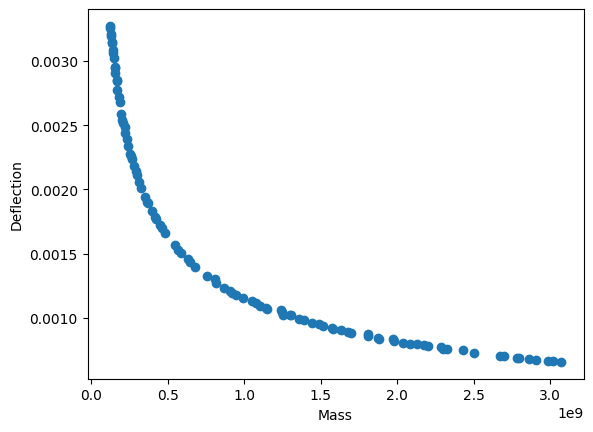

In [ ]:
# plot the Pareto approximate set; adapted from David's water programming post
fig = plt.figure()
plt.scatter([s.objectives[0] for s in nondominated_solutions],
            [s.objectives[1] for s in nondominated_solutions])
plt.xlabel('Mass')
plt.ylabel('Deflection')